Tutorial from [Neural-Networks-from-Scratch by lionelmessi6410]https://github.com/lionelmessi6410/Neural-Networks-from-Scratch

# Import Library

In [9]:
import numpy as np
import matplotlib.pyplot as plt
#from tensorflow.keras.datasets.cifar10 import cifar10_data
from tensorflow import keras

# Helper functions

In [35]:
def show_images(image, num_row = 2, num_col = 5):
    image_size = int(np.sqrt(image.shape[-1]))
    image = np.reshape(image, (image.shape[0], image_size, image_size,3))
    fig, axes = plt.subplot(num_row, num_col, figsize = (1.5*num_col, 2* num_row))
    for i in range(num_row*num_col):
        ax = axes[i//num_col, i %num_col]
        ax = imshow(image[i],cmap = 'gray', vmin = 0, vmax = 1)
        ax.axis('off')
    plt.tight_layout()
    plt.show()
    
def one_hot(x, k, dtype = np.float32):
    """Create a one-hot encoding of x of size k."""
    return np.array(x[:, None] == np.arange(k), dtype)    

# Acquire Data

In [28]:
(X_train, y_train),(X_test, y_test) = keras.datasets.cifar10.load_data()

In [29]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((50000, 32, 32, 3), (50000, 1), (10000, 32, 32, 3), (10000, 1))

In [31]:
# Normalize
X_train = X_train/255
X_test = X_test/255

# One-hot encode labels
num_labels = 10
example = y_train.shape[0]
y_train_en = one_hot(y_train.astype('int32'),num_labels)

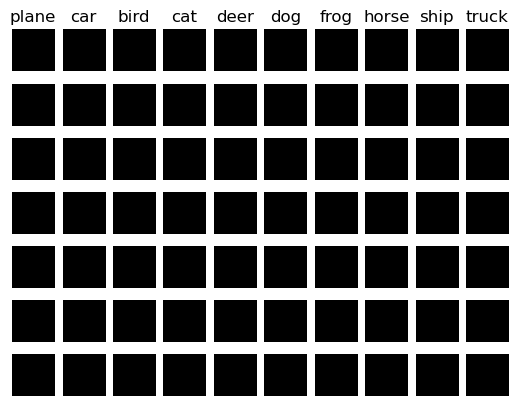

In [37]:
print("Training data: {} {}".format(X_train.shape, y_train.shape))
print("Test data: {} {}".format(X_test.shape, y_test.shape))
show_images(X_train)

In [ ]:
class DeepNeuralNetwork():
    def __init__(self, sizes, activation = 'sigmoid'):
        self.sizes = sizes
        
        # Choose activation function
        if activation == 'relu':
            self.activation = self.relu
        elif activation == 'sigmoid':
            self.activation = self.sigmoid
        else:
            raise ValueError("Activation function is currently not support, please use 'relu' or 'sigmoid' instead.")

        # save all weights 
        self.params = self.initialize()
        # Save all intermediate values, i.e. activations        
        self.cache = {}

    def relu(self, x, derivative = False):
        '''
            Derivative of ReLU is a bit more complicated since it is not differentiable at x = 0
        
            Forward path:
            relu(x) = max(0, x)
            In other word,
            relu(x) = 0, if x < 0
                    = x, if x >= 0
        
            Backward path:
            ∇relu(x) = 0, if x < 0
                     = 1, if x >=0
        '''
        if derivative:
            x = np.where(x < 0, 0, x)
            x = np.where(x >= 0, 1, x)
            return x
        return np.maximum(0, x)

    def sigmoid(self, x, derivative = False):
        '''
            Forward path:
            σ(x) = 1 / 1+exp(-z)
            
            Backward path:
            ∇σ(x) = exp(-z) / (1+exp(-z))^2
        '''
        if derivative:
            return (np.exp(-x))/((np.exp(-x)+1)**2)
        return 1/(1 + np.exp(-x))

    def softmax(self, x):
        '''
            softmax(x) = exp(x) / ∑exp(x)
        '''
        # Numerically stable with large exponentials
        '''
        in order to improve training stability, 
        deep neural networks typically use a numerically stable softmax,
        which subtracts the max of the vector on which softmax is being performed
        in order to ensure that the result does not blow up to infinity.
        '''
        exps = np.exp(x - x.max()) 
        return exps / np.sum(exps, axis=0)

    def initialize(self):
        # number of nodes in each layer
        input_layer = self.sizes[0]
        hidden_layer = self.sizes[1]
        output_layer = self.sizes[2]

        params = {
            "W1": np.random.randn(hidden_layer, input_layer) * np.sqrt(1. / input_layer), # why??? "* np.sqrt(1. / input_layer)" why??
            "b1": np.zeros((hidden_layer, 1)) * np.sqrt(1./input_layer),
            "W2": np.random.randn(output_layer, hidden_layer) * np.sqrt(1. / hidden_layer), # Answer: Weight Initialization - Xavier initialization
            "b2": np.zeros((output_layer, 1)) * np.sqrt(1./hidden_layer)
        }
        return params

    def initialize_momentum_optimizer(self):
        momentum_opt = {
            "W1": np.zeros(self.params["W1"].shape),
            "b1": np.zeros(self.params["b1"].shape),
            "W2": np.zeros(self.params["W2"].shape),
            "b2": np.zeros(self.params["b2"].shape)
        }
        return momentum_opt

    def feed_forward(self, x):
        '''
            y = σ(wX + b)
        '''
        self.cache["X"] = x
        self.cache["Z1"] = np.matmul(self.params['W1'], self.cache['X'].T) + self.params['b1']
        self.cache["A1"] = self.activation(self.cache["Z1"])
        self.cache["Z2"] = np.matmul(self.params['W2'], self.cache["A1"]) + self.params['b2']
        self.cache["A2"] = self.softmax(self.cache['Z2'])
        return self.cache['A2']

    def back_propagate(self, y, output):
        '''
            This is the backpropagation algorithm, for calculating the updates
            of the neural network's parameters.

            Note: There is a stability issue that causes warnings. This is 
                  caused  by the dot and multiply operations on the huge arrays.
                  
                  RuntimeWarning: invalid value encountered in true_divide
                  RuntimeWarning: overflow encountered in exp
                  RuntimeWarning: overflow encountered in square
        '''
        current_batch_size = y.shape[0]
        dZ2 = output - y.T
        dW2 = (1./current_batch_size) * np.matmul(dZ2, self.cache["A1"].T)
        db2 = (1./current_batch_size) * np.sum(dZ2, axis = 1, keepdims = True)

        dA1 = np.matmul(self.params["W2"].T, dZ2)
        dZ1 = dA1 * self.activation(self.cache["Z1"], derivative = True)
        dW1 = (1./current_batch_size) * np.matmul(dZ1, self.cache["X"])
        db1 = (1./current_batch_size) * np.sum(dZ1, axis = 1, keepdims = True)

        self.grads = {"W1": dW1, "b1":db1, "W2":dW2, "b2":db2}
        return self.grads

    def cross_entropy_loss(self, y, output):
        '''
            L(y, ŷ) = −∑ylog(ŷ).
        '''
        l_sum = np.sum(np.multiply(y.T, np.log(output)))
        m = y.shape[0]
        l = -(1./m) * l_sum
    
        return l

    def optimize(self, l_rate=0.1, beta=.9):
        '''
            Stochatic Gradient Descent (SGD):
            θ^(t+1) <- θ^t - η∇L(y, ŷ)
            
            Momentum:
            v^(t+1) <- βv^t + (1-β)∇L(y, ŷ)^t
            θ^(t+1) <- θ^t - ηv^(t+1)
        '''
        if self.optimizer == "sgd":
            for key in self.params:
                self.params[key] = self.params[key] - l_rate * self.grads[key]
        elif self.optimizer == "momentum":
            for key in self.params:
                self.momentum_opt[key] = (beta * self.momentum_opt[key] + (1. - beta) * self.grads[key])
                self.params[key] = self.params[key] - l_rate * self.momentum_opt[key]
        else:
            raise ValueError("Optimizer is currently not support, please use 'sgd' or 'momentum' instead.")

    def accuracy(self, y, output):
        return np.mean(np.argmax(y, axis=-1) == np.argmax(output.T, axis = -1))

    def train(self, x_train, y_train, x_test, y_test, epochs=10, 
              batch_size=64, optimizer='momentum', l_rate=0.1, beta=.9):
        # Hyperparameters
        self.epochs = epochs
        self.batch_size = batch_size
        num_batches = -(-x_train.shape[0] // self.batch_size)

        # Initialize optimizer
        self.optimizer = optimizer
        if self.optimizer == 'momentum':
            self.momentum_opt = self.initialize_momentum_optimizer()

        start_time = time.time()
        template = "Epoch {}: {:.2f}s,train acc={:.2f}, train loss={:.2f}, test acc={:.2f}, test loss={:.2f}"

        # Train
        for i in range(self.epochs):
            # Shuffle
            permutation = np.random.permutation(x_train.shape[0])
            x_train_shuffled = x_train[permutation]
            y_train_shuffled = y_train[permutation]

            for j in range(num_batches):
                # Batch
                begin = j * self.batch_size
                end = min(begin + self.batch_size, x_train.shape[0] - 1)
                x = x_train_shuffled[begin:end]
                y = y_train_shuffled[begin:end]

                # Forward Propagation
                output = self.feed_forward(x)
                # Back propagation
                grad = self.back_propagate(y, output)
                # Optimize
                self.optimize(l_rate=l_rate, beta=beta)

            # Evaluate performance
            # Training data
            output = self.feed_forward(x_train)
            train_acc = self.accuracy(y_train, output)
            train_loss = self.cross_entropy_loss(y_train, output)
            # Test data
            output = self.feed_forward(x_test)
            test_acc = self.accuracy(y_test, output)
            test_loss = self.cross_entropy_loss(y_test, output)        
            print(template.format(i+1, time.time()-start_time,train_acc, train_loss, test_acc, test_loss))